In [ ]:
!pip install --upgrade tfds-nightly
!pip install --upgrade tensorflow tensorflow-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existin

In [ ]:
import time
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# EMNIST 데이터셋 로드
ds_builder = tfds.builder("emnist/balanced")
ds_builder.download_and_prepare()
ds_info = ds_builder.info
dataset = ds_builder.as_data_source()

# Label Mapping
label_mapping = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
    'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't'
]

# 이미지 크기 조정 및 정규화
def preprocess(image, label):
    image = tf.image.resize(image, (32, 32))    # LeNet-5는 32x32 입력 사용
    image = tf.image.grayscale_to_rgb(image)    # 그레이스케일 이미지를 RGB로 변환
    image = image / 255.0                       # 정규화
    return image, label

# 데이터 생성 (train, test)
X = []
y = []
for example in dataset['train']:
    X.append(example['image'])
    y.append(example['label'])

X_test = []
y_test = []
for example in dataset['test']:
    X_test.append(example['image'])
    y_test.append(example['label'])

X = np.array(X)
y = np.array(y)

X_test = np.array(X_test)
y_test = np.array(y_test)


# dataset 분할 (train:validation = 5:1), test dataset은 emnist dataset에 있는 것으로 사용
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=1/6, random_state=42)

# 원-핫 인코딩
y_train = tf.keras.utils.to_categorical(y_train, num_classes=47)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=47)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=47)

# 데이터셋 구성 및 배치 설정
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(preprocess).shuffle(1000).batch(32)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).map(preprocess).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(preprocess).batch(32)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/112800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/balanced/incomplete.W7LMIE_3.1.0/emnist-train.array_record*...:   0…

Generating test examples...:   0%|          | 0/18800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/balanced/incomplete.W7LMIE_3.1.0/emnist-test.array_record*...:   0%…

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/balanced/3.1.0. Subsequent calls will reuse this data.


In [ ]:
%load_ext tensorboard

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, Dropout, BatchNormalization

tf.random.set_seed(42)
np.random.seed(42)

# LeNet-5 모델 정의 (activation function : relu)
class LeNet5_relu(Sequential):
  def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), activation='relu', input_shape=input_shape, padding="same"))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2),padding='valid'))
    self.add(BatchNormalization())
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    self.add(BatchNormalization())
    self.add(Conv2D(120, kernel_size=(5,5), strides=(1,1), activation='relu', padding='valid'))
    self.add(Flatten())
    self.add(BatchNormalization())
    self.add(Dense(84, activation='relu'))
    self.add(Dropout(0.5))
    self.add(Dense(num_classes, activation='softmax'))



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Model: "le_net5_relu_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 16, 16, 6)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 6)           │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 16)          │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 6, 6, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 6, 6, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 2, 2, 120)           │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 480)                 │           1,920 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 84)                  │          40,404 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 47)                  │           3,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,183 (383.53 KB)

 Trainable params: 97,179 (379.61 KB)

 Non-trainable params: 1,004 (3.92 KB)

Epoch 1/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.5813 - loss: 1.5111 - val_accuracy: 0.8463 - val_loss: 0.4572
Epoch 2/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.8013 - loss: 0.6179 - val_accuracy: 0.8597 - val_loss: 0.3992
Epoch 3/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.8194 - loss: 0.5426 - val_accuracy: 0.8653 - val_loss: 0.3839
Epoch 4/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.8289 - loss: 0.5031 - val_accuracy: 0.8660 - val_loss: 0.3742
Epoch 5/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8391 - loss: 0.4721 - val_accuracy: 0.8681 - val_loss: 0.3663
Epoch 6/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.8439 - loss: 0.4528 - val_accuracy: 0.8735 - val_loss: 0.3528
Epoch 7/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8473 - loss: 0.4382 - val_accuracy: 0.8781 - val_loss: 0.3610
Epoch 8/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.8519 - loss: 0

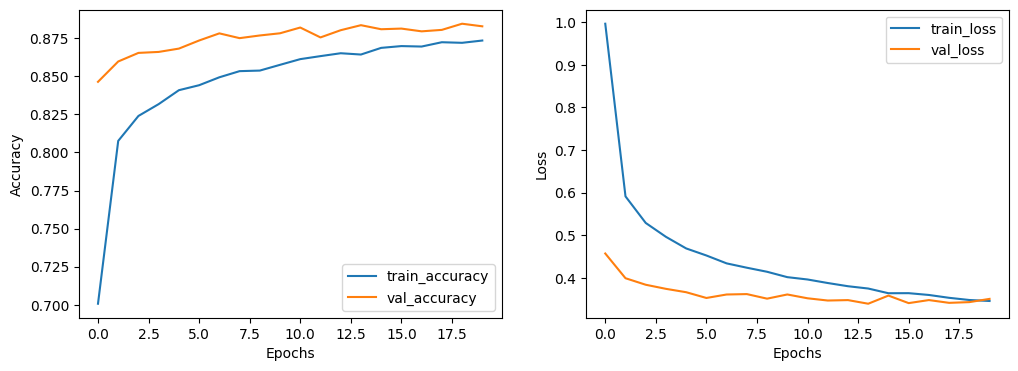

588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8851 - loss: 0.3534
Test Loss: 0.3660, Test Accuracy: 0.8824
훈련시간 : 6.18 minutes.
평균 추론 시간: 0.0002 seconds.


In [ ]:
input_shape = (32,32,3)
num_classes = 47

# 모델 생성
model_r1 = LeNet5_relu(input_shape,num_classes)
model_r1.summary()

# Learning rate
Learning_rate = 1e-3
model = model_r1

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=Learning_rate), loss=categorical_crossentropy, metrics=['accuracy'])

# 모델 학습
start_time = time.time()  # 학습 시작 시간
history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset)
training_time = time.time() - start_time  # 학습 시간 계산

# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 모델 평가
start_time = time.time()  # 추론 시작 시간
test_loss, test_accuracy = model.evaluate(test_dataset)
end_time = time.time()  # 추론 종료 시간
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"훈련시간 : {training_time/60:.2f} minutes.")
print(f"평균 추론 시간: {average_inference_time:.4f} seconds.")

In [ ]:
%load_ext tensorboard

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, Dropout, BatchNormalization, Layer, Add, ReLU

tf.random.set_seed(42)
np.random.seed(42)

# LeNet-5 모델 정의 (activation function : relu)

class ResidualBlock(Layer):
    def __init__(self, filters, kernel_size):
        super(ResidualBlock, self).__init__()
        self.conv1 = Conv2D(filters, kernel_size, padding='same', activation='relu')
        self.conv2 = Conv2D(filters, kernel_size, padding='same')
        self.add = Add()
        self.relu = ReLU()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.add([x, inputs])
        x = self.relu(x)
        return x

class LeNet5_res(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape, padding="same"))
        self.add(ResidualBlock(6, (5, 5)))  # 잔차 블록 추가
        self.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(BatchNormalization())

        self.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='valid'))
        self.add(ResidualBlock(16, (3, 3)))  # 잔차 블록 추가
        self.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(BatchNormalization())

        self.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
        self.add(Flatten())
        self.add(BatchNormalization())
        self.add(Dense(84, activation='relu'))
        self.add(Dropout(0.5))
        self.add(Dense(num_classes, activation='softmax'))



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "le_net5_res_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_1 (ResidualBlock)     │ (None, 32, 32, 6)           │           1,812 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_4                  │ (None, 16, 16, 6)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 16, 16, 6)           │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 14, 14, 16)          │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_2 (ResidualBlock)     │ (None, 14, 14, 16)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_5                  │ (None, 7, 7, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 7, 7, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 3, 3, 120)           │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1080)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 1080)                │           4,320 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 84)                  │          90,804 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 47)                  │           3,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,115 (605.92 KB)

 Trainable params: 152,911 (597.31 KB)

 Non-trainable params: 2,204 (8.61 KB)

Epoch 1/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - accuracy: 0.5778 - loss: 1.5333 - val_accuracy: 0.8394 - val_loss: 0.4671
Epoch 2/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.7913 - loss: 0.6374 - val_accuracy: 0.8553 - val_loss: 0.4133
Epoch 3/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.8106 - loss: 0.5729 - val_accuracy: 0.8661 - val_loss: 0.3793
Epoch 4/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8213 - loss: 0.5348 - val_accuracy: 0.8611 - val_loss: 0.3937
Epoch 5/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.8300 - loss: 0.5066 - val_accuracy: 0.8695 - val_loss: 0.3909
Epoch 6/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8343 - loss: 0.4874 - val_accuracy: 0.8756 - val_loss: 0.3649
Epoch 7/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.8408 - loss: 0.4676 - val_accuracy: 0.8720 - val_loss: 0.4007
Epoch 8/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.8420 - loss: 0

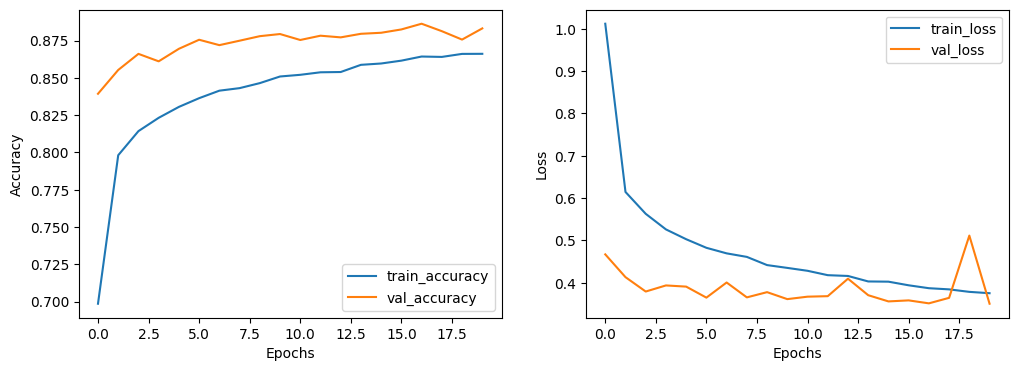

588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8839 - loss: 0.3552
Test Loss: 0.3665, Test Accuracy: 0.8818
훈련시간 : 6.80 minutes.
평균 추론 시간: 0.0001 seconds.


In [ ]:
input_shape = (32,32,3)
num_classes = 47

# 모델 생성
model_r2 = LeNet5_res(input_shape,num_classes)
model_r2.summary()

# Learning rate
Learning_rate = 1e-3
model = model_r2

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=Learning_rate), loss=categorical_crossentropy, metrics=['accuracy'])

# 모델 학습
start_time = time.time()  # 학습 시작 시간
history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset)
training_time = time.time() - start_time  # 학습 시간 계산

# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 모델 평가
start_time = time.time()  # 추론 시작 시간
test_loss, test_accuracy = model.evaluate(test_dataset)
end_time = time.time()  # 추론 종료 시간
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"훈련시간 : {training_time/60:.2f} minutes.")
print(f"평균 추론 시간: {average_inference_time:.4f} seconds.")

In [ ]:
%load_ext tensorboard

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, Dropout, BatchNormalization, Layer, Add, ReLU

tf.random.set_seed(42)
np.random.seed(42)

# LeNet-5 모델 정의 (activation function : relu)

class ResidualBlock(Layer):
    def __init__(self, filters, kernel_size):
        super(ResidualBlock, self).__init__()
        self.conv1 = Conv2D(filters, kernel_size, padding='same', activation='relu')
        self.conv2 = Conv2D(filters, kernel_size, padding='same')
        self.add = Add()
        self.relu = ReLU()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.add([x, inputs])
        x = self.relu(x)
        return x

class LeNet5_res_2(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape, padding="same"))
        #self.add(ResidualBlock(6, (5, 5)))  # 잔차 블록 추가
        self.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(BatchNormalization())

        self.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='valid'))
        self.add(ResidualBlock(16, (3, 3)))  # 잔차 블록 추가
        self.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(BatchNormalization())

        self.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
        self.add(Flatten())
        self.add(BatchNormalization())
        self.add(Dense(84, activation='relu'))
        self.add(Dropout(0.5))
        self.add(Dense(num_classes, activation='softmax'))



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "le_net5_res_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)                   │ (None, 32, 32, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_6                  │ (None, 16, 16, 6)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 6)           │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 14, 14, 16)          │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_3 (ResidualBlock)     │ (None, 14, 14, 16)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_7                  │ (None, 7, 7, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 7, 7, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 3, 3, 120)           │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1080)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 1080)                │           4,320 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 84)                  │          90,804 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 47)                  │           3,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 153,303 (598.84 KB)

 Trainable params: 151,099 (590.23 KB)

 Non-trainable params: 2,204 (8.61 KB)

Epoch 1/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - accuracy: 0.5819 - loss: 1.5243 - val_accuracy: 0.8395 - val_loss: 0.4538
Epoch 2/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 0.7914 - loss: 0.6425 - val_accuracy: 0.8602 - val_loss: 0.4041
Epoch 3/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.8117 - loss: 0.5681 - val_accuracy: 0.8655 - val_loss: 0.3955
Epoch 4/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8256 - loss: 0.5212 - val_accuracy: 0.8693 - val_loss: 0.3930
Epoch 5/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.8315 - loss: 0.5044 - val_accuracy: 0.8670 - val_loss: 0.3786
Epoch 6/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.8346 - loss: 0.4815 - val_accuracy: 0.8738 - val_loss: 0.3679
Epoch 7/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.8391 - loss: 0.4677 - val_accuracy: 0.8765 - val_loss: 0.3675
Epoch 8/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.8453 - loss: 0

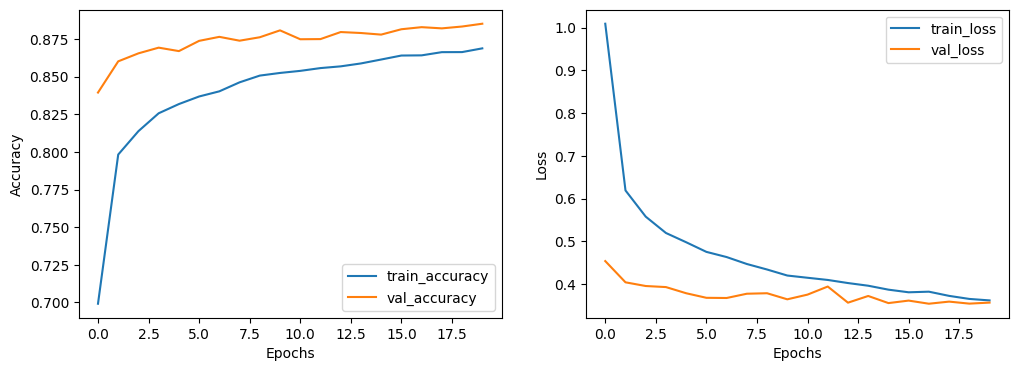

588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8868 - loss: 0.3743
Test Loss: 0.3905, Test Accuracy: 0.8843
훈련시간 : 7.38 minutes.
평균 추론 시간: 0.0003 seconds.


In [ ]:
input_shape = (32,32,3)
num_classes = 47

# 모델 생성
model_r3 = LeNet5_res_2(input_shape,num_classes)
model_r3.summary()

# Learning rate
Learning_rate = 1e-3
model = model_r3

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=Learning_rate), loss=categorical_crossentropy, metrics=['accuracy'])

# 모델 학습
start_time = time.time()  # 학습 시작 시간
history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset)
training_time = time.time() - start_time  # 학습 시간 계산

# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 모델 평가
start_time = time.time()  # 추론 시작 시간
test_loss, test_accuracy = model.evaluate(test_dataset)
end_time = time.time()  # 추론 종료 시간
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"훈련시간 : {training_time/60:.2f} minutes.")
print(f"평균 추론 시간: {average_inference_time:.4f} seconds.")

In [ ]:
%load_ext tensorboard

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, Dropout, BatchNormalization, Layer, Add, ReLU

tf.random.set_seed(42)
np.random.seed(42)

# LeNet-5 모델 정의 (activation function : relu)

class ResidualBlock(Layer):
    def __init__(self, filters, kernel_size):
        super(ResidualBlock, self).__init__()
        self.conv1 = Conv2D(filters, kernel_size, padding='same', activation='relu')
        self.conv2 = Conv2D(filters, kernel_size, padding='same')
        self.add = Add()
        self.relu = ReLU()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.add([x, inputs])
        x = self.relu(x)
        return x

class LeNet5_res_3(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape, padding="same"))
        self.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(BatchNormalization())

        self.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='valid'))
        self.add(ResidualBlock(16, (3, 3)))  # 잔차 블록 추가
        self.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(BatchNormalization())

        self.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
        self.add(ResidualBlock(120, (5, 5)))
        self.add(Flatten())
        self.add(BatchNormalization())
        self.add(Dense(84, activation='relu'))
        self.add(Dropout(0.5))
        self.add(Dense(num_classes, activation='softmax'))



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "le_net5_res_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 32, 32, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_8                  │ (None, 16, 16, 6)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 16, 16, 6)           │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 14, 14, 16)          │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_4 (ResidualBlock)     │ (None, 14, 14, 16)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_9                  │ (None, 7, 7, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 7, 7, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 3, 3, 120)           │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_5 (ResidualBlock)     │ (None, 3, 3, 120)           │         720,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1080)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 1080)                │           4,320 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 84)                  │          90,804 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 47)                  │           3,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 873,543 (3.33 MB)

 Trainable params: 871,339 (3.32 MB)

 Non-trainable params: 2,204 (8.61 KB)

Epoch 1/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - accuracy: 0.6030 - loss: 1.4340 - val_accuracy: 0.8408 - val_loss: 0.4734
Epoch 2/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.8166 - loss: 0.5759 - val_accuracy: 0.8340 - val_loss: 0.4924
Epoch 3/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8368 - loss: 0.5037 - val_accuracy: 0.8616 - val_loss: 0.4217
Epoch 4/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.8523 - loss: 0.4507 - val_accuracy: 0.8639 - val_loss: 0.4118
Epoch 5/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.8620 - loss: 0.4143 - val_accuracy: 0.8739 - val_loss: 0.3824
Epoch 6/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.8690 - loss: 0.3850 - val_accuracy: 0.8736 - val_loss: 0.3768
Epoch 7/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - accuracy: 0.8762 - loss: 0.3613 - val_accuracy: 0.8663 - val_loss: 0.4082
Epoch 8/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8793 - loss: 0

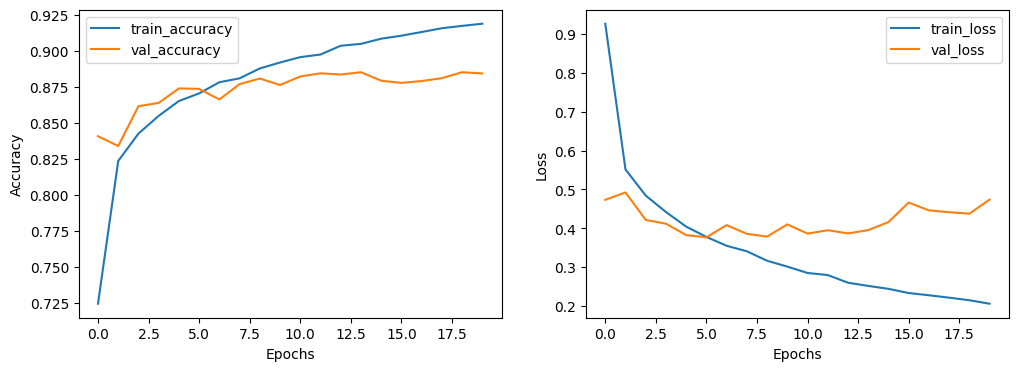

588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8840 - loss: 0.4782
Test Loss: 0.4961, Test Accuracy: 0.8826
훈련시간 : 7.21 minutes.
평균 추론 시간: 0.0001 seconds.


In [ ]:
input_shape = (32,32,3)
num_classes = 47

# 모델 생성
model_r4 = LeNet5_res_3(input_shape,num_classes)
model_r4.summary()

# Learning rate
Learning_rate = 1e-3
model = model_r4

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=Learning_rate), loss=categorical_crossentropy, metrics=['accuracy'])

# 모델 학습
start_time = time.time()  # 학습 시작 시간
history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset)
training_time = time.time() - start_time  # 학습 시간 계산

# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 모델 평가
start_time = time.time()  # 추론 시작 시간
test_loss, test_accuracy = model.evaluate(test_dataset)
end_time = time.time()  # 추론 종료 시간
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"훈련시간 : {training_time/60:.2f} minutes.")
print(f"평균 추론 시간: {average_inference_time:.4f} seconds.")

In [ ]:
%load_ext tensorboard

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, Dropout, BatchNormalization

tf.random.set_seed(42)
np.random.seed(42)

# LeNet-5 모델 정의 (activation function : relu)
class LeNet5_relu(Sequential):
  def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), activation='relu', input_shape=input_shape, padding="same"))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2),padding='valid'))
    self.add(BatchNormalization())
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    self.add(BatchNormalization())
    self.add(Conv2D(120, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(Conv2D(120, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
    self.add(Flatten())
    self.add(BatchNormalization())
    self.add(Dense(84, activation='relu'))
    self.add(Dropout(0.5))
    self.add(Dense(num_classes, activation='softmax'))



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Model: "le_net5_relu_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)                   │ (None, 32, 32, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_10                 │ (None, 16, 16, 6)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 16, 16, 6)           │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 14, 14, 16)          │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 12, 12, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_11                 │ (None, 6, 6, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 6, 6, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 4, 4, 120)           │          17,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 2, 2, 120)           │         129,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 480)                 │           1,920 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 84)                  │          40,404 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 47)                  │           3,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,183 (770.25 KB)

 Trainable params: 196,179 (766.32 KB)

 Non-trainable params: 1,004 (3.92 KB)

Epoch 1/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - accuracy: 0.5784 - loss: 1.5117 - val_accuracy: 0.8441 - val_loss: 0.4646
Epoch 2/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.8013 - loss: 0.6048 - val_accuracy: 0.8509 - val_loss: 0.4561
Epoch 3/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.8277 - loss: 0.5247 - val_accuracy: 0.8643 - val_loss: 0.4089
Epoch 4/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.8359 - loss: 0.4854 - val_accuracy: 0.8672 - val_loss: 0.3867
Epoch 5/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.8464 - loss: 0.4522 - val_accuracy: 0.8732 - val_loss: 0.3644
Epoch 6/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.8551 - loss: 0.4246 - val_accuracy: 0.8785 - val_loss: 0.3482
Epoch 7/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.8584 - loss: 0.4094 - val_accuracy: 0.8758 - val_loss: 0.3707
Epoch 8/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.8605 - loss: 0

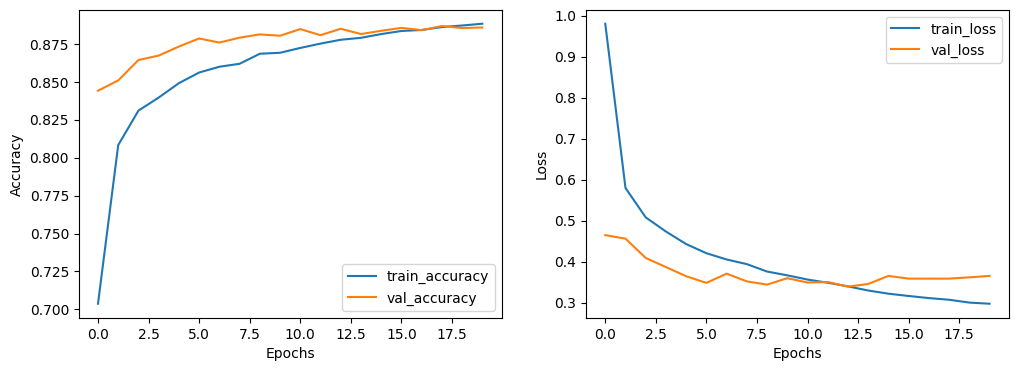

588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8883 - loss: 0.3624
Test Loss: 0.3850, Test Accuracy: 0.8852
훈련시간 : 6.54 minutes.
평균 추론 시간: 0.0001 seconds.


In [ ]:
input_shape = (32,32,3)
num_classes = 47

# 모델 생성
model_r1 = LeNet5_relu(input_shape,num_classes)
model_r1.summary()

# Learning rate
Learning_rate = 1e-3
model = model_r1

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=Learning_rate), loss=categorical_crossentropy, metrics=['accuracy'])

# 모델 학습
start_time = time.time()  # 학습 시작 시간
history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset)
training_time = time.time() - start_time  # 학습 시간 계산

# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 모델 평가
start_time = time.time()  # 추론 시작 시간
test_loss, test_accuracy = model.evaluate(test_dataset)
end_time = time.time()  # 추론 종료 시간
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"훈련시간 : {training_time/60:.2f} minutes.")
print(f"평균 추론 시간: {average_inference_time:.4f} seconds.")